# Machine Learning-Assisted Swimming Pool Detector

## Description:

Object detection and machine learning are at the heart of the field of computer vision. Self-driving cars, visual recognition systems, and video surveillance are a few among many technologies that became possible because of machine learning and in particular, deep learning. Therefore, utilizing such methods and techniques, can save lot of money and time in many industries. One example is real estate or insurance companies. The property valuation can be a time consuming and a daunting task. Improvements to the property such as renovation or building a new swimming pool can drastically change the value of a property. Therefore, it is important to identify such changes accurately and efficiently. In this project, I am going to use machine learning techniques to explore and analyze geographical aerial images for a swimming pool detector. To create such a detector system, I need images to process and train my model. As of now, I found a public image data set of ~150MB available on Kaggle. My plan is to incrementally improve the model by starting with simple classifiers (e.g. Gaussian or SVM) and if necessary move onto more sophisticated ones such as GMM or Neural Nets.

## Code:

Load some libraries and setups for plotting

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from numpy import *
from matplotlib.pylab import *

# Some beutification
rcParams['figure.figsize'] = (10,7)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.family'] = 'SF Pro Text'
rcParams['font.weight'] = 400
rcParams['font.size'] = 10
rcParams['xtick.color'] = '#222222'
rcParams['ytick.color'] = '#222222'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 13
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 12
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We need to find if there’s a pool at any pixel in an image. To start with we need labelled data. To get these I manually estimated the center of all the pools that I could find in the images. I then picked a neighborhood of 6 pixel radius and assumed all these pixels were also pool pixels. It isn't great labelling, but it'll naver be so in real-life. In the following code I load the data, make the class labels, and plot them to make sure they make sense.



## Step-by-step Data Processing

### 1. Load the images

**NOTE: I noticed the Kaggle data to some extent has cleaned the data by patching up the images into smaller pieces (with pool and without pool) and provided the pixel in XML file for parsing. But as of now I am going to practice getting the image and labelling it myself (will be needed in the future if I need more training data, more than Kaggle one).**

For now, I will upload two images and consider them for testing and training. For training, I need labelled data. This means for an image I have to label the pool pixels. 

Let's take a look at Beverely Hills in California, neighbourhood where lots of houses have swimming pools:
- I have installed google earth for high resolution images
- I zoomed into an area and saved the aerial image with the resolution of 635x867 pixels (~3.4MB)

In [27]:
datapath = './'

# Load the images for trainig and test
tr = imread( datapath+'Beverly_Hills_Train.png')[:,:,:3]
ts = imread( datapath+'Beverly_Hills_Test.png')[:,:,:3]

### 2. Find the center of the pools

- I have manually extracted the pixels accosiated with the center of the pools for both trainig and testing !

In [28]:
# Training pool center positions
cr = array( [
    [455, 176], [646, 148], [674, 212], [417, 164], [307, 210],
    [207, 275], [269, 367], [565, 434], [771, 464], [668, 523],
    [401, 589], [438, 609], [342, 705], [ 84, 676], [ 14, 501],
    [257,   8], [188, 709], [246, 684], [293, 620], [799, 384],
    [756, 100], [3,   220], [89,  366], [530, 318],
])


# Testing pool center positions
cs = [
    [ 46,  85], [137, 187], [384,  75], [612, 110], [516, 142],
    [529, 184], [614, 359], [546, 385], [430, 436], [330, 394],
    [254, 435], [517, 508], [503, 712], [543, 754], [417, 747],
    [288, 682], [107, 767], [ 18, 738], [ 11, 853], [ 50, 702],
    [ 97, 620], [ 58, 564], [632, 565], [231, 597], [269, 569],
]

- To prevent having just one point representing the pool, I have picked a neighborhood of 5 pixel radius and assumed all these pixels were also pool pixels. This of course is not neat and precise but can be improved in the future by properly labelling the pools and extracting their edge pixles. 

In [29]:
# Approximate with a 5 pixel radius for pool centers - training
nn_pixel = 5
xx,yy = meshgrid( range( tr.shape[1]), range( tr.shape[0]))
mr = 0*tr[:,:,0]
for i in range( len( rij)):
    mr += (sqrt( (xx-rij[i][0])**2 + (yy-rij[i][1])**2) < nn_pixel)

# Approximate with a 5 pixel radius for pool centers - test
xx,yy = meshgrid( range( ts.shape[1]), range( ts.shape[0]))
ms = 0*ts[:,:,0]
for i in range( len( sij)):
    ms += (sqrt( (xx-sij[i][0])**2 + (yy-sij[i][1])**2) < nn_pixel)

### 3. Exploratory plots for the labels

Plotting the labels and check if the manual labeling make sesne and match the images ! 


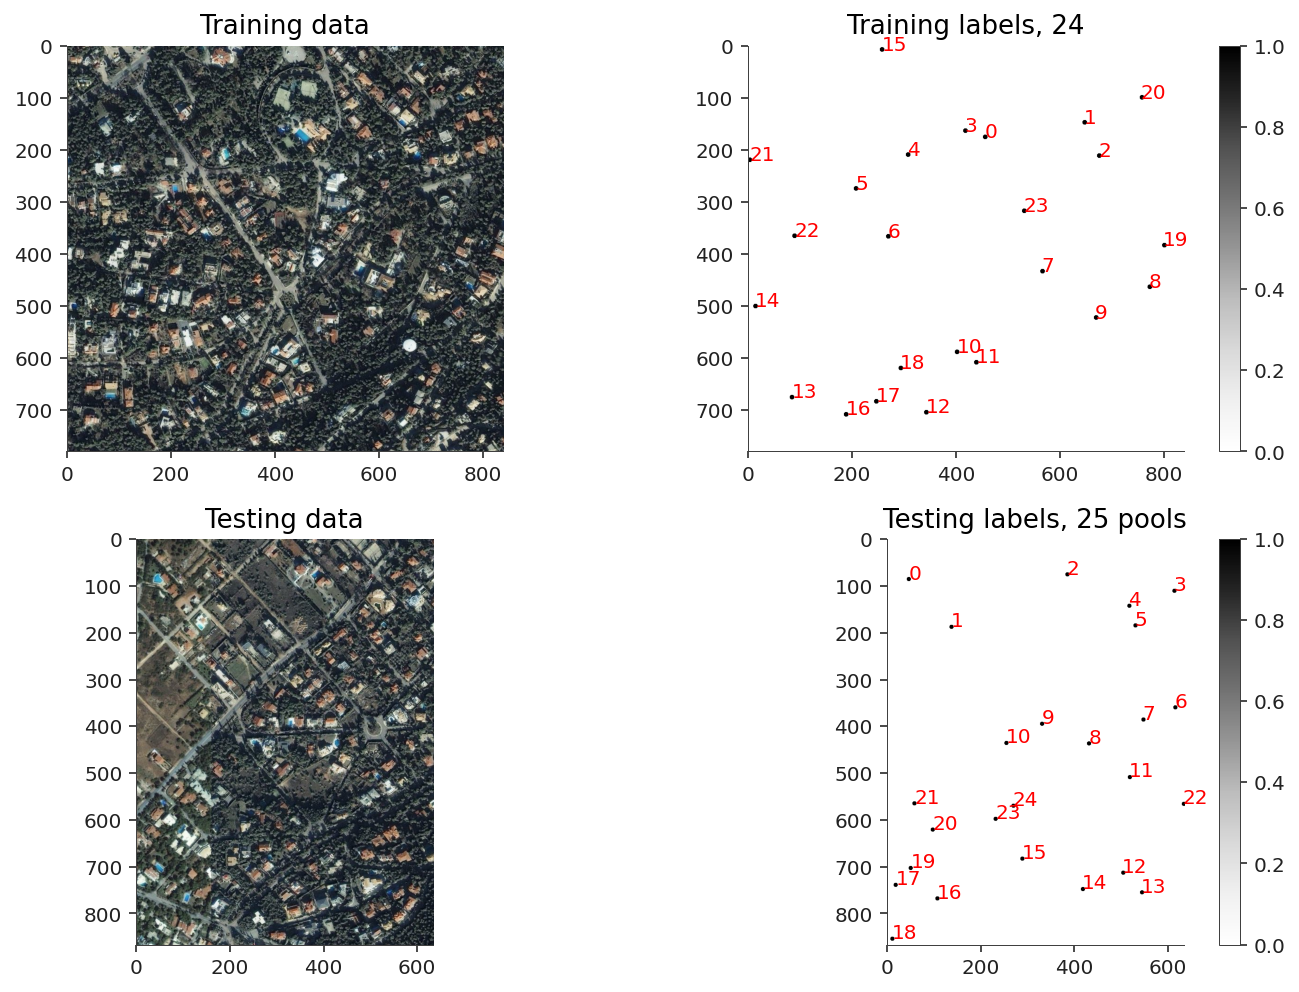

In [30]:
# plot the images
subplot( 2, 2, 1), imshow( tr), title( 'Training data')
subplot( 2, 2, 2), imshow( mr), title('Training labels, {}'.format(len(rij))), colorbar()
for i,p in enumerate( rij):
    text( p[0], p[1], str(i), color='r')
subplot( 2, 2, 3), imshow( ts), title( 'Testing data')
subplot( 2, 2, 4), imshow( ms), title( 'Testing labels, {} pools'.format(len(sij))), colorbar()
for i,p in enumerate( sij):
    text( p[0], p[1], str(i), color='r')
tight_layout()

Labels are in good agreement with the images.

## Next Steps:

### 4. Create patches of images

For trainig, I need lot of data. So I need to cut the training image into patches of maybe 10x10 pixels, which wil contain patches having pools in them and patches without pool, so our classifer can detect between pool and non pool cases. 

**NOTE: this is exactly why in Kaggle data sate the images are not wide and are zoomed in images containig pool or non-pool cases.**

Therefore, I will use their labels and images for trainig

### 5. Vectorize the patches (using their pixels) as features 

Since the image is 635x867 times 3 (rgb) dimension, it might be a good idea to reduce the dimension maybe using Principal Component Analysis (PCA)or other methods.

### 6. Train a classifier 

Now with reduced dimension we can start training our classifier. For classifier I plan trying simpler methods first ( e.g. SVM, Gassian, etc) and if they don't perform well I will move on to Neural Nets and deep learning